In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from sklearn.model_selection import train_test_split
from PIL import Image
from glob import glob
import os
import random

In [2]:
# 1. Dataset Class Implementation
class BrainMRIDataset(Dataset):
    def __init__(self, dataframe, image_transform=None, mask_transform=None, target_size=(256, 256)):
        self.dataframe = dataframe
        self.image_transform = image_transform
        self.mask_transform = mask_transform
        self.target_size = target_size
        
    def __len__(self):
        return len(self.dataframe)
    
    def __getitem__(self, idx):
        # Load image and mask
        image_path = self.dataframe.iloc[idx]['image_filename']
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        mask_path = self.dataframe.iloc[idx]['mask_images']
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        
        # Preprocess
        image = cv2.resize(image, self.target_size)
        mask = cv2.resize(mask, self.target_size)
        
        image = image.astype(np.float32) / 255.0
        mask = mask.astype(np.float32) / 255.0
        
        # Convert to PIL Images for transforms
        image = Image.fromarray((image * 255).astype(np.uint8))
        mask = Image.fromarray((mask * 255).astype(np.uint8))
        
        if self.image_transform:
             # Set seed to ensure the same transformations for both image and mask
            seed = torch.seed()  # Get a random seed
            random.seed(seed)
            torch.manual_seed(seed)
            image = self.image_transform(image)

            # Apply the same seed to the mask transformation
            random.seed(seed)
            torch.manual_seed(seed)
            mask = self.image_transform(mask)
            
        mask = mask.unsqueeze(0)
        
        return image, mask

In [3]:
def display_batch_mri(image_batch, mask_batch, num_images=None, figsize=(15, 8)):
    """
    Display a batch of MRI images and their corresponding masks side by side
    
    Args:
        image_batch: torch.Tensor of shape (batch_size, channels, height, width)
        mask_batch: torch.Tensor of shape (batch_size, 1, height, width)
        num_images: Number of images to display (defaults to all images in batch)
        figsize: Size of the figure (width, height)
    """
    # Convert tensors to numpy arrays and move to CPU if needed
    if torch.is_tensor(image_batch):
        images = image_batch.cpu().numpy()
    if torch.is_tensor(mask_batch):
        masks = mask_batch.cpu().numpy()
    
    # Get batch size
    batch_size = images.shape[0]
    if num_images is None:
        num_images = batch_size
    else:
        num_images = min(num_images, batch_size)
    
    # Calculate grid dimensions
    num_cols = min(4, num_images)
    num_rows = 2  # One row for images, one for masks
    
    # Create figure
    fig = plt.figure(figsize=figsize)
    
    for idx in range(num_images):
        # Plot original image
        plt.subplot(num_rows, num_cols, idx + 1)
        img = np.transpose(images[idx], (1, 2, 0))  # CHW -> HWC
        plt.imshow(img)
        plt.axis('off')
        plt.title(f'MRI Image {idx+1}')
        
        # Plot mask
        plt.subplot(num_rows, num_cols, idx + 1 + num_cols)
        mask = masks[idx, 0]  # Take first channel
        mask = np.moveaxis(mask, 0, -1)
        plt.imshow(mask, cmap='gray')
        plt.axis('off')
        plt.title(f'Mask {idx+1}')
    
    plt.tight_layout()
    plt.show()

# Example usage with your dataset structure:
def create_mri_dataframe(base_path):
    """Create a dataframe with MRI image and mask paths"""
    image_files = []
    mask_files = []
    
    for root, _, files in os.walk(base_path):
        for file in files:
            if file.endswith('.tif'):
                full_path = os.path.join(root, file)
                if '_mask' in file:
                    mask_files.append(full_path)
                else:
                    image_files.append(full_path)
    
    return pd.DataFrame({
        'image_filename': sorted(image_files),
        'mask_images': sorted(mask_files)
    })

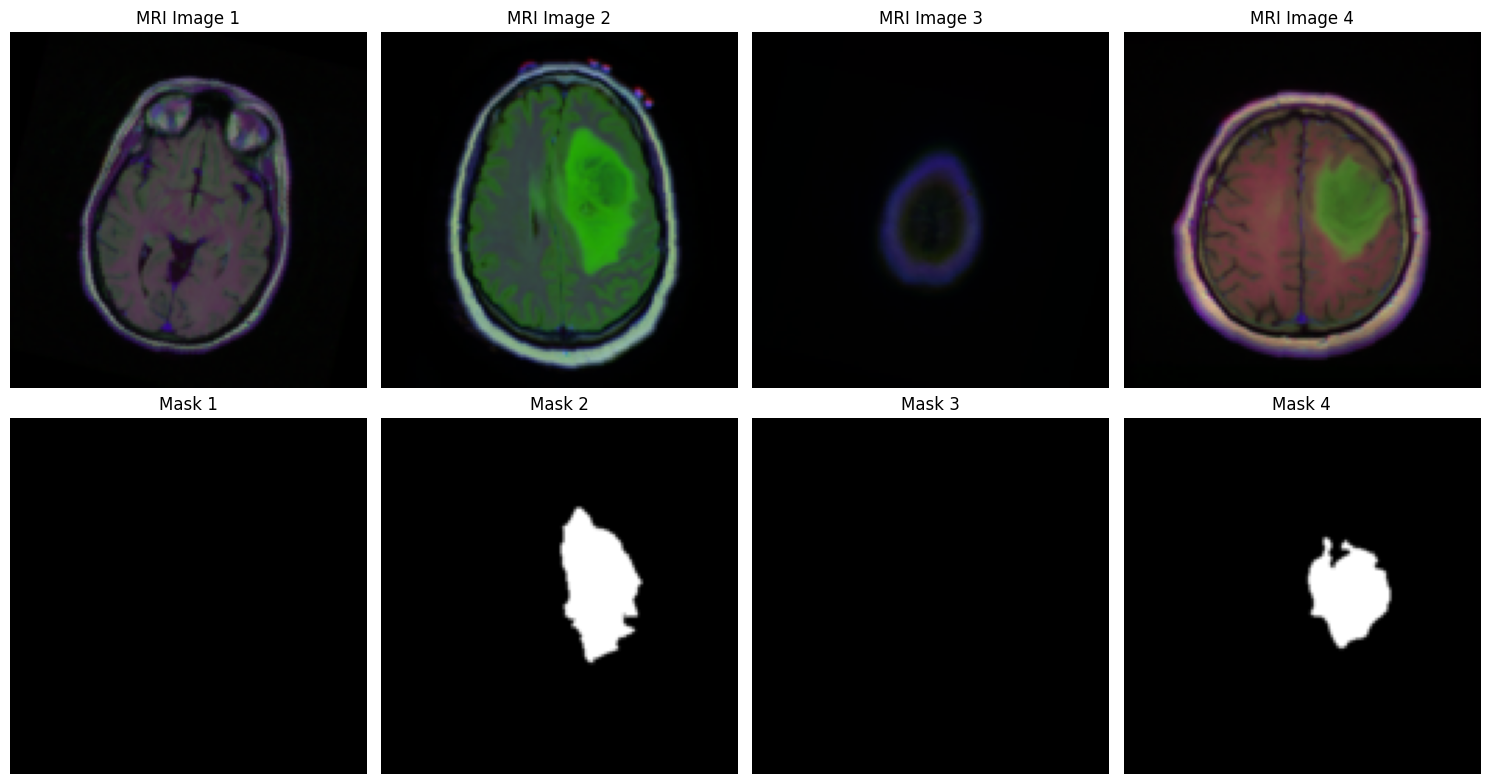

In [4]:
from torchvision import transforms
# Create your dataframe
df = create_mri_dataframe(r"D:\KMITL\4D\Project\BrainSegNet\Brain_MRI")

# Set up transforms
ttransforms = transforms.Compose([
            transforms.RandomRotation(20),
            transforms.RandomHorizontalFlip(),
            transforms.Resize((128, 128)),
            transforms.ToTensor()
        ])
mask = transforms.Compose([
            transforms.ToTensor()
        ])

# Create dataset
dataset = BrainMRIDataset(
    dataframe=df,
    image_transform=ttransforms,
    mask_transform=mask
)

# Create dataloader
dataloader = DataLoader(dataset, batch_size=4, shuffle=True)

# Get a batch and display it
images, masks = next(iter(dataloader))
display_batch_mri(images, masks)

In [5]:
# 2. U-Net Model Implementation
class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()
        
        # Encoder path
        self.enc1 = self.conv_block(3, 64)
        self.enc2 = self.conv_block(64, 128)
        self.enc3 = self.conv_block(128, 256)
        self.enc4 = self.conv_block(256, 512)
        
        # Middle
        self.middle = self.conv_block(512, 1024)
        
        # Decoder path
        self.upconv4 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
        self.dec4 = self.conv_block(1024, 512)
        
        self.upconv3 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.dec3 = self.conv_block(512, 256)
        
        self.upconv2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.dec2 = self.conv_block(256, 128)
        
        self.upconv1 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.dec1 = self.conv_block(128, 64)
        
        self.final = nn.Conv2d(64, 1, kernel_size=1)
    
    def conv_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )
    
    def forward(self, x):
        # Encoder path with skip connections
        enc1 = self.enc1(x)
        enc2 = self.enc2(F.max_pool2d(enc1, kernel_size=2))
        enc3 = self.enc3(F.max_pool2d(enc2, kernel_size=2))
        enc4 = self.enc4(F.max_pool2d(enc3, kernel_size=2))
        
        # Middle
        middle = self.middle(F.max_pool2d(enc4, kernel_size=2))
        
        # Decoder path with skip connections
        dec4 = self.dec4(torch.cat([self.upconv4(middle), enc4], dim=1))
        dec3 = self.dec3(torch.cat([self.upconv3(dec4), enc3], dim=1))
        dec2 = self.dec2(torch.cat([self.upconv2(dec3), enc2], dim=1))
        dec1 = self.dec1(torch.cat([self.upconv1(dec2), enc1], dim=1))
        
        return torch.sigmoid(self.final(dec1))

In [6]:
from torch.utils.tensorboard import SummaryWriter

def dice_coefficient(y_true, y_pred, smooth=100):
    y_true_flatten = y_true.view(-1)
    y_pred_flatten = y_pred.view(-1)
    intersection = (y_true_flatten * y_pred_flatten).sum()
    union = y_true_flatten.sum() + y_pred_flatten.sum()
    return (2.0 * intersection + smooth) / (union + smooth)

def dice_coefficient_loss(y_true, y_pred, smooth=100):
    return 1 - dice_coefficient(y_true, y_pred, smooth)

def train_model(model, train_loader, val_loader, loss_fn, optimizer, epochs, device, scheduler=None, save_path='models/', log_dir='runs/'):
    history = {'train_loss': [], 'val_loss': []}
    best_val_loss = float('inf')
    best_epoch = -1

    # Ensure save path exists
    if not os.path.exists(save_path):
        os.makedirs(save_path)

    # Create a TensorBoard writer
    writer = SummaryWriter(log_dir=log_dir)

    for epoch in range(epochs):
        print(f"\nEpoch {epoch + 1}/{epochs}")
        model.train()
        running_loss = 0.0
        total_batches = len(train_loader)  # Total number of batches in training data

        # Training loop
        for batch_idx, (images, masks) in enumerate(train_loader, 1):  # Start batch_idx at 1
            images = images.to(device)
            masks = masks.to(device)
            
            # Forward pass
            outputs = model(images)
            loss = loss_fn(outputs, masks)
            
            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item() * images.size(0)

            # Print batch progress
            print(f"Batch {batch_idx}/{total_batches} - Loss: {loss.item():.4f}", end='\r')  # Display on same line
        
        # Compute epoch loss
        epoch_loss = running_loss / len(train_loader.dataset)
        history['train_loss'].append(epoch_loss)
        
        # Validation phase (if val_loader is provided)
        val_loss = 0.0
        if val_loader is not None:
            model.eval()
            with torch.no_grad():
                for val_images, val_masks in val_loader:
                    val_images = val_images.to(device)
                    val_masks = val_masks.to(device)
                    
                    val_outputs = model(val_images)
                    val_loss_batch = loss_fn(val_outputs, val_masks)
                    val_loss += val_loss_batch.item() * val_images.size(0)
                    
            val_loss = val_loss / len(val_loader.dataset)
            history['val_loss'].append(val_loss)

            # Check if this is the best epoch so far
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                best_epoch = epoch + 1

        # Log the loss values to TensorBoard
        writer.add_scalar('Loss/Train', epoch_loss, epoch + 1)
        if val_loader is not None:
            writer.add_scalar('Loss/Validation', val_loss, epoch + 1)

        # Print epoch results
        print(f"\nEpoch {epoch + 1}/{epochs} - Train Loss: {epoch_loss:.4f}", end='')
        if val_loader is not None:
            print(f" - Validation Loss: {val_loss:.4f}")

        # Save model after each epoch
        model_save_path = os.path.join(save_path, f'model_epoch_{epoch + 1}.pth')
        torch.save(model.state_dict(), model_save_path)
        print(f"Model saved to {model_save_path}")

        # Step the learning rate scheduler
        if scheduler is not None:
            scheduler.step()

    # Log the best epoch and validation loss to TensorBoard
    writer.add_text('Best Epoch', f"Best Epoch: {best_epoch} with Validation Loss: {best_val_loss:.4f}")

    writer.close()
    
    print(f"\nBest Epoch: {best_epoch} - Best Validation Loss: {best_val_loss:.4f}")

    return history


In [7]:
# 4. Model Evaluation Function
def evaluate_model(model, df_test, device, im_height, im_width):
    model.eval()
    
    for i in range(5):
        index = np.random.randint(0, len(df_test))
        img_path = df_test.iloc[index]['image_filename']
        mask_path = df_test.iloc[index]['mask_images']
        
        img = cv2.imread(img_path)
        img = cv2.resize(img, (im_height, im_width))
        img = img.astype(np.float32) / 255.0
        img_tensor = torch.from_numpy(img).permute(2, 0, 1).unsqueeze(0).to(device)
        
        with torch.no_grad():
            pred = model(img_tensor).cpu().squeeze().numpy() > 0.5
        
        plt.figure(figsize=(12, 6))
        plt.subplot(1, 3, 1)
        plt.imshow(img)
        plt.title('Original Image')
        
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        mask = cv2.resize(mask, (im_height, im_width))
        
        plt.subplot(1, 3, 2)
        plt.imshow(mask, cmap='gray')
        plt.title('Original Mask')
        
        plt.subplot(1, 3, 3)
        plt.imshow(pred, cmap='gray')
        plt.title('Prediction')
        
        plt.show()

In [8]:
def load_data(data_paths):
    """
    Load MRI images and masks from multiple directories
    Args:
        data_paths (list): List of paths to the dataset directories
    Returns:
        pandas.DataFrame: DataFrame containing image and mask file paths
    """
    all_images = []
    all_masks = []
    
    for data_path in data_paths:
        print(f"Looking for data in: {data_path}")
        
        # Get all image and mask paths
        image_filenames = glob(f"{data_path}/*/*.tif")
        # Filter out mask files from image files
        image_filenames = [f for f in image_filenames if 'mask' not in f.lower()]
        
        # Get corresponding mask files
        mask_images = glob(f"{data_path}/*/*mask.tif")
        
        print(f"Found {len(image_filenames)} images and {len(mask_images)} masks in {data_path}")
        
        all_images.extend(sorted(image_filenames))
        all_masks.extend(sorted(mask_images))
    
    # Check if files were found
    if not all_images or not all_masks:
        raise ValueError(
            f"No images found in the specified paths. "
            f"Found total of {len(all_images)} images and {len(all_masks)} masks. "
            "Please check the data directory paths and file extensions."
        )
    
    print(f"\nTotal dataset size: {len(all_images)} images and {len(all_masks)} masks")
    
    # Create DataFrame
    df = pd.DataFrame({
        'image_filename': all_images,
        'mask_images': all_masks
    })
    
    return df

import os

def main():
    # Set parameters
    im_height, im_width = 256, 256
    batch_size = 4
    epochs = 2
    learning_rate = 1e-4
    model_save_path = './trained_model.pth'  # Path to save the model
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")

    try:
        # Define paths to both datasets
        data_paths = [
            "./Brain_MRI/kaggle_3m",
            "./Brain_MRI/lgg-mri-segmentation/kaggle_3m"
        ]
        
        # Load and combine datasets
        df = load_data(data_paths)
        
        # Print first few entries to verify correct loading
        print("\nFirst few entries in the dataset:")
        print(df.head())
        
        # Split the data
        if len(df) < 2:
            raise ValueError(f"Not enough samples to split. Found only {len(df)} samples.")
            
        df_train, df_test = train_test_split(df, test_size=0.1, random_state=42)
        print(f"\nTraining samples: {len(df_train)}, Test samples: {len(df_test)}")
        
        # Define transforms
        train_transforms = transforms.Compose([
            transforms.RandomRotation(20),
            transforms.RandomHorizontalFlip(),
            transforms.Resize((im_height, im_width)),
            transforms.ToTensor()
        ])
        mask_transform = transforms.Compose([transforms.ToTensor()])
        
        # Create datasets and loaders
        train_dataset = BrainMRIDataset(df_train, train_transforms, mask_transform)
        val_dataset = BrainMRIDataset(df_test, train_transforms, mask_transform)
        
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
        
        # Initialize model, optimizer, and scheduler
        model = UNet().to(device)
        optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
        scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)
        
        # Train model
        history = train_model(model, train_loader, val_loader, dice_coefficient_loss, 
                            optimizer, epochs, device, scheduler)
        
        # Save the trained model
        torch.save(model.state_dict(), model_save_path)
        print(f"Model saved to {model_save_path}")
        
        # Evaluate model
        evaluate_model(model, df_test, device, im_height, im_width)
        
        return model, history
        
    except Exception as e:
        print(f"Error occurred: {str(e)}")
        raise



Using device: cuda
Looking for data in: ./Brain_MRI/kaggle_3m
Found 3929 images and 3929 masks in ./Brain_MRI/kaggle_3m
Looking for data in: ./Brain_MRI/lgg-mri-segmentation/kaggle_3m
Found 3929 images and 3929 masks in ./Brain_MRI/lgg-mri-segmentation/kaggle_3m

Total dataset size: 7858 images and 7858 masks

First few entries in the dataset:
                                      image_filename   
0  ./Brain_MRI/kaggle_3m\TCGA_CS_4941_19960909\TC...  \
1  ./Brain_MRI/kaggle_3m\TCGA_CS_4941_19960909\TC...   
2  ./Brain_MRI/kaggle_3m\TCGA_CS_4941_19960909\TC...   
3  ./Brain_MRI/kaggle_3m\TCGA_CS_4941_19960909\TC...   
4  ./Brain_MRI/kaggle_3m\TCGA_CS_4941_19960909\TC...   

                                         mask_images  
0  ./Brain_MRI/kaggle_3m\TCGA_CS_4941_19960909\TC...  
1  ./Brain_MRI/kaggle_3m\TCGA_CS_4941_19960909\TC...  
2  ./Brain_MRI/kaggle_3m\TCGA_CS_4941_19960909\TC...  
3  ./Brain_MRI/kaggle_3m\TCGA_CS_4941_19960909\TC...  
4  ./Brain_MRI/kaggle_3m\TCGA_CS_4941_1996

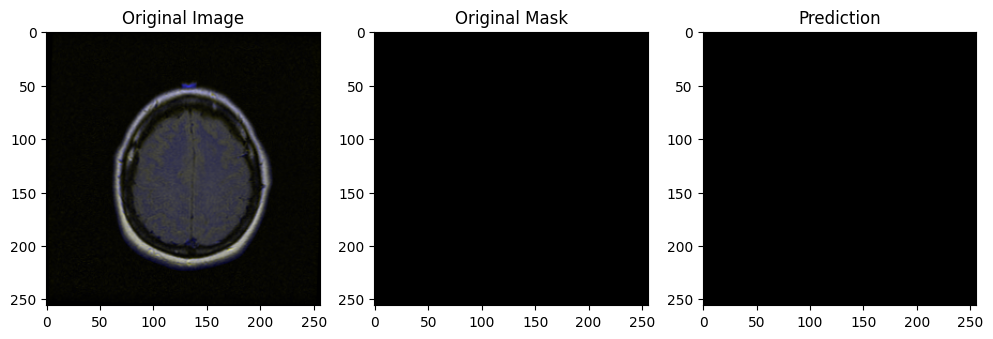

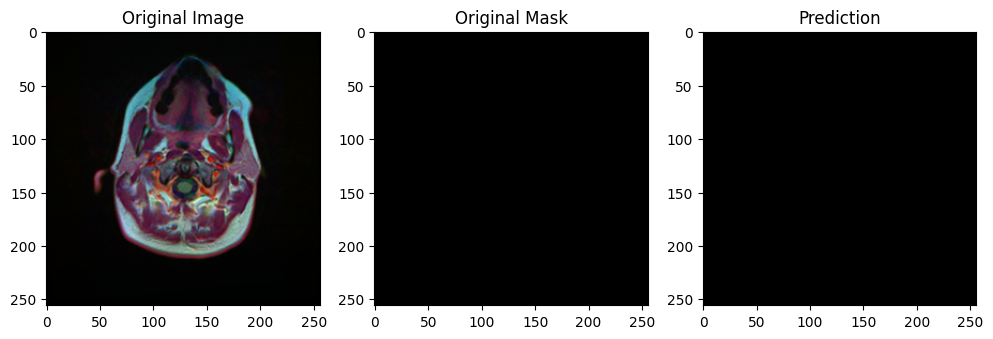

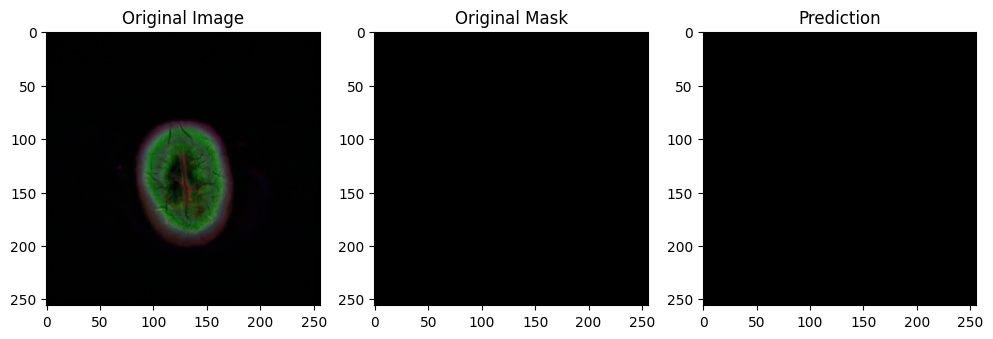

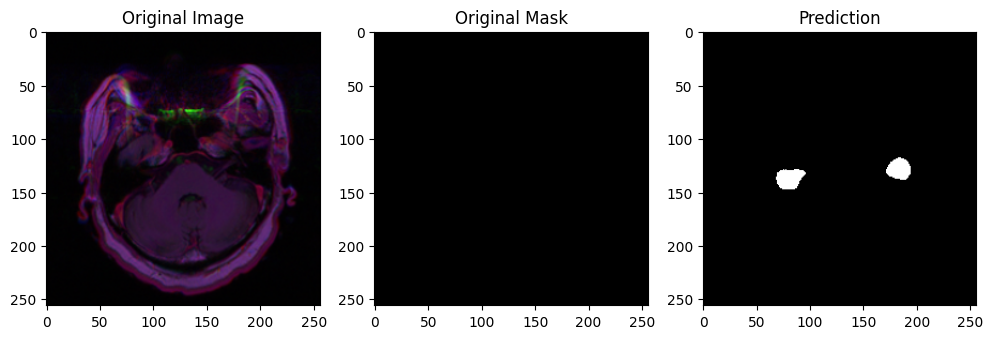

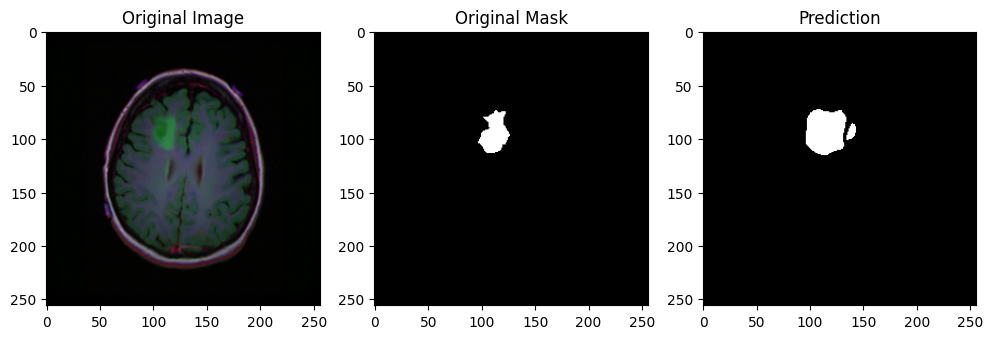

In [9]:
if __name__ == "__main__":
    model, history = main()

C:\Users\sitth\AppData\Local\Temp\ipykernel_8832\3150982871.py:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_pth, map_location=dev

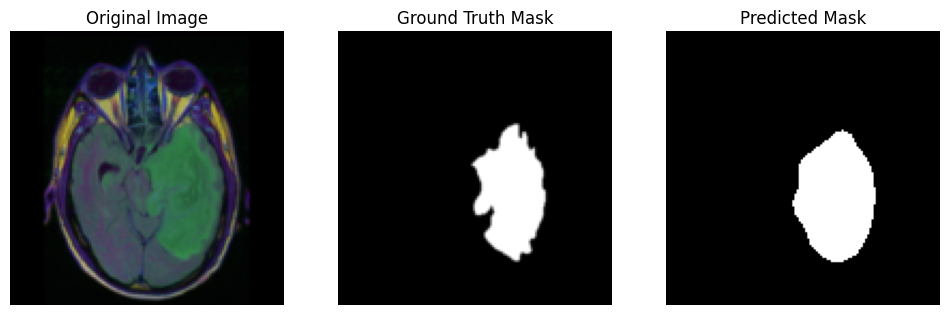

In [10]:
import torch
import matplotlib.pyplot as plt
from torchvision import transforms
from PIL import Image


def single_image_inference(image_pth, model_pth, device):
    # Initialize and load the model
    model = UNet().to(device)  # Ensure UNet() matches your architecture
    model.load_state_dict(torch.load(model_pth, map_location=device))
    model.eval()  # Set model to evaluation mode

    # Define image transformation pipeline
    transform = transforms.Compose([
        transforms.Resize((128, 128)),  # Adjust size as needed
        transforms.ToTensor()
    ])

    # Load and preprocess the image and corresponding mask
    img = transform(Image.open(image_pth)).float().to(device)
    real_mask = transform(Image.open(image_pth.replace(".tif", "_mask.tif"))).float().to(device)  # Adjust if mask name differs
    img = img.unsqueeze(0)  # Add batch dimension for the model

    # Perform inference
    with torch.no_grad():  # Disable gradient calculation for inference
        pred_mask = model(img)

    # Post-process predicted mask (assuming model outputs a binary mask)
    pred_mask = pred_mask.squeeze(0).cpu().detach()
    pred_mask = pred_mask.permute(1, 2, 0).numpy()
    pred_mask = (pred_mask > 0.5).astype(float)  # Apply threshold for binary classification

    # Prepare the image and ground truth mask for display
    img = img.squeeze(0).cpu().detach().permute(1, 2, 0)  # Reshape image for display
    real_mask = real_mask.squeeze(0).cpu().detach().numpy()

    # Plot image, ground truth mask, and predicted mask
    fig, ax = plt.subplots(1, 3, figsize=(12, 4))
    
    ax[0].imshow(img, cmap="gray")
    ax[0].set_title("Original Image")
    ax[0].axis('off')
    
    ax[1].imshow(real_mask, cmap="gray")
    ax[1].set_title("Ground Truth Mask")
    ax[1].axis('off')
    
    ax[2].imshow(pred_mask, cmap="gray")
    ax[2].set_title("Predicted Mask")
    ax[2].axis('off')
    
    plt.show()


if __name__ == "__main__":
    SINGLE_IMG_PATH = "Brain_MRI/lgg-mri-segmentation/kaggle_3m/TCGA_CS_5393_19990606/TCGA_CS_5393_19990606_8.tif"
    MODEL_PATH = "models/model_epoch_2.pth"

    device = "cuda" if torch.cuda.is_available() else "cpu"
    single_image_inference(SINGLE_IMG_PATH, MODEL_PATH, device)
